# Barycenter icons (64x64)

Load the icon images as 2D binary measures, build a barycenter problem,
and compare two barycenter solvers.


In [18]:
import sys, os
from jax import config

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'
# config.update('jax_enable_x64', True)
sys.path.insert(0, os.path.abspath(os.path.join('..')))

import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

from uot.data.dataset_loader import load_image_as_binary_grid
from uot.data.measure import DiscreteMeasure
from uot.problems.barycenter_problem import BarycenterProblem
from uot.utils.costs import cost_euclid_squared
from uot.utils.notebook_helpers import barycenter_inputs
from uot.utils.generator_helpers.get_axes import get_axes
from uot.utils.generate_nd_grid import generate_nd_grid

from uot.solvers.sinkhorn.barycenter import barycenter_sinkhorn
from uot.solvers.back_and_forth.barycenter import backnforth_barycenter_sqeuclidean_nd
from uot.solvers.pdlp_barycenter import PDLPBarycenterSolver


In [14]:
def normalize_field(field, eps=1e-12):
    field = np.asarray(field, dtype=np.float64)
    field = np.clip(field, 0.0, None)
    total = field.sum()
    return field / total if total > eps else field


def aligned_grid_field(points, weights, grid_points, grid_shape):
    aligned = DiscreteMeasure(points=points, weights=weights).weights_on(
        grid_points, include_zeros=True
    )
    field = np.asarray(aligned).reshape(grid_shape)
    return normalize_field(field)


def plot_field(ax, field, axes=None, title='', cmap='Greys', vmin=None, vmax=None):
    if axes is not None:
        extent = (
            float(axes[0][0]),
            float(axes[0][-1]),
            float(axes[1][0]),
            float(axes[1][-1]),
        )
        im = ax.imshow(
            # field.T, extent=extent, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower',
            field.T, extent=extent, cmap=cmap, vmin=vmin, vmax=vmax
        )
    else:
        im = ax.imshow(field.T, cmap=cmap, vmin=vmin, vmax=vmax)
        # im = ax.imshow(field.T, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
    ax.set_title(title)
    ax.axis('off')
    return im


In [3]:
img_dir = 'imgs'
img_names = sorted([
    name for name in os.listdir(img_dir)
    if name.lower().endswith(('.png', '.jpg', '.jpeg', '.webp'))
])

size = (64, 64)
all_measures = {
    name: load_image_as_binary_grid(
        os.path.join(img_dir, name),
        size=size,
        threshold=0.5,
        invert=True,
        normalize=True,
        axes_mode='normalized',
    )

    for name in img_names
}
selected_measures = {
    'cristo_redentor.jpg',
    'motherland_monument_kyiv.jpg',
    'toronto_tower.jpg',
}
selected_names = [name for name in img_names if name in selected_measures]

measures = [all_measures[name] for name in selected_names]
# Fallback: if any measure is empty after thresholding, relax settings
# fixed_measures = []
# for name in selected_names:
#     m = all_measures[name]
#     if np.asarray(m.weights_nd).sum() == 0:
#         m = load_image_as_binary_grid(
#             os.path.join(img_dir, name),
#             size=size,
#             threshold=0.2,
#             invert=False,
#             normalize=True,
#             axes_mode='normalized',
#         )
#     fixed_measures.append(m)
# measures = fixed_measures
lambdas = np.ones(len(measures)) / len(measures)
problem = BarycenterProblem(
    name='icon-barycenter',
    measures=measures,
    cost_fn=cost_euclid_squared,
    lambdas=lambdas,
)


np.max(field)=np.float64(0.0016155088852988692) np.min(field)=np.float64(0.0) np.sum(field)=np.float64(0.9999999999999999)
np.max(field)=np.float64(0.0014265335235378032) np.min(field)=np.float64(0.0) np.sum(field)=np.float64(1.0)
np.max(field)=np.float64(0.007142857142857143) np.min(field)=np.float64(0.0) np.sum(field)=np.float64(1.0)


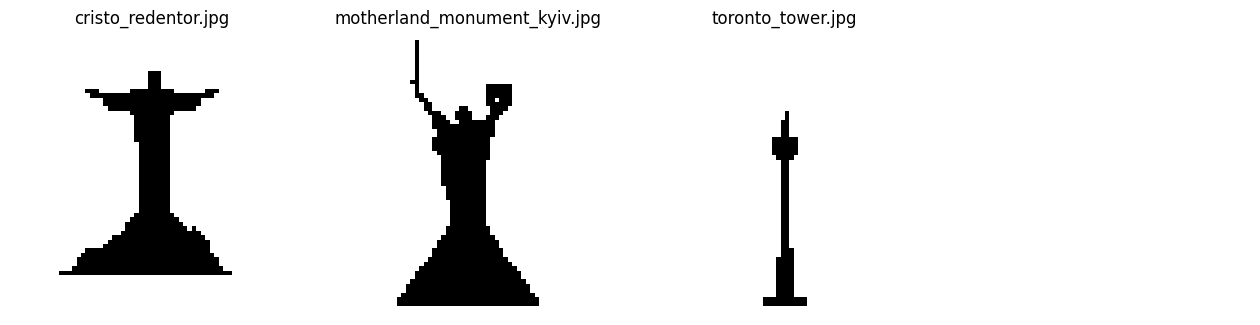

In [4]:
cols = 4
rows = int(np.ceil(len(measures) / cols))
fig, axes_plot = plt.subplots(rows, cols, figsize=(3.2 * cols, 3.2 * rows))
axes_plot = np.asarray(axes_plot).reshape(-1)

for ax, name, measure in zip(axes_plot, selected_names, measures):
    field = np.asarray(measure.weights_nd)
    print(f"{np.max(field)=} {np.min(field)=} {np.sum(field)=}")
    ax.imshow(field, cmap='Greys')
    ax.set_title(name)
    ax.axis('off')

for ax in axes_plot[len(measures):]:
    ax.axis('off')

fig.tight_layout()
plt.show()


In [5]:
measures, lambdas, cost, meas_array, support = barycenter_inputs(
    problem,
    support_mode='shared',
    shared_mode='union',
    return_support=True,
)

# Use the measure grid directly to avoid coordinate mismatches
axes = measures[0].axes
grid_points = np.asarray(generate_nd_grid(axes, use_jax=False))
grid_shape = np.asarray(measures[0].weights_nd).shape

measure_fields = []
for measure in measures:
    points, weights = measure.to_discrete(include_zeros=True)
    measure_fields.append(
        aligned_grid_field(points, weights, grid_points, grid_shape)
    )


In [6]:
print(f'Loaded {len(measures)} measures: {selected_names}')
for idx, field in enumerate(measure_fields):
    print(f"{np.max(field)=} {np.min(field)=}")
    # name = selected_names[idx] if idx < len(selected_names) else f'measure_{idx+1}'
    # weights = np.asarray(measure.weights_nd)
    # print(f'  {idx+1}. {name}: shape={weights.shape}, min={weights.min():.3g}, max={weights.max():.3g}, sum={weights.sum():.3g}')


Loaded 3 measures: ['cristo_redentor.jpg', 'motherland_monument_kyiv.jpg', 'toronto_tower.jpg']
np.max(field)=np.float64(0.0016155088852988695) np.min(field)=np.float64(0.0)
np.max(field)=np.float64(0.0014265335235378032) np.min(field)=np.float64(0.0)
np.max(field)=np.float64(0.007142857142857143) np.min(field)=np.float64(0.0)


In [7]:
b_sinkhorn, info_sinkhorn = barycenter_sinkhorn(
    measures=meas_array,
    cost=cost,
    lambdas=lambdas,
    reg=1e-4,
    tol=1e-4,
    maxiter=400,
    return_diagnostics=True,
)

print(f"Sinkhorn iterations = {info_sinkhorn['iterations']}")
print(f"Sinkhorn error = {info_sinkhorn['error']}")

sinkhorn_field = aligned_grid_field(
    support, np.asarray(b_sinkhorn), grid_points, grid_shape
)


Sinkhorn iterations = 121
Sinkhorn error = 9.901860903482884e-05


In [8]:
measures_weights = [jnp.asarray(field) for field in measure_fields]

b_bnf, diag_bnf = backnforth_barycenter_sqeuclidean_nd(
    weights=[float(x) for x in np.asarray(lambdas)],
    measures_weights=measures_weights,
    coordinates=[jnp.asarray(ax) for ax in axes],
    outer_maxiter=10,
    stopping_tol=2e-4,
    relaxation=1.0,
    transport_stepsize=1.0,
    transport_maxiter=1000,
    transport_tol=1e-4,
)

print(f"Back-and-forth iterations = {diag_bnf['iterations']}")
print(f"Back-and-forth final residual = {diag_bnf['final_residual']}")
print(f"Back-and-forth max transport error = {diag_bnf['max_transport_error']}")
print(f"Back-and-forth max marginal error = {diag_bnf['max_marginal_error']}")

bnf_field = normalize_field(np.asarray(b_bnf))


Internal: bfm converged after 125 iterations
Internal: bfm converged after 127 iterations
Internal: bfm converged after 127 iterations
Internal: bfm converged after 124 iterations
Internal: bfm converged after 126 iterations
Internal: bfm converged after 162 iterations
Back-and-forth iterations = 2
Back-and-forth final residual = 0.0
Back-and-forth max transport error = 0.26852908730506897
Back-and-forth max marginal error = 0.00041498453356325626


In [19]:
marginals = [
    DiscreteMeasure(points=support, weights=meas_array[i], name=f'measure_{i+1}')
    for i in range(meas_array.shape[0])
]

solver = PDLPBarycenterSolver()
result_pdlp = solver.solve(
    marginals=marginals,
    costs=[cost],
    weights=lambdas,
    reg=1e+1,
    maxiter=2000,
    tol=1e-4,
)

b_pdlp = np.asarray(result_pdlp['barycenter'])
print(f"PDLP iterations = {result_pdlp['iterations']}")
print(f"PDLP error = {result_pdlp['error']}")

pdlp_field = aligned_grid_field(
    support, b_pdlp, grid_points, grid_shape
)


PDLP iterations = 895
PDLP error = 6.0828300775028765e-05


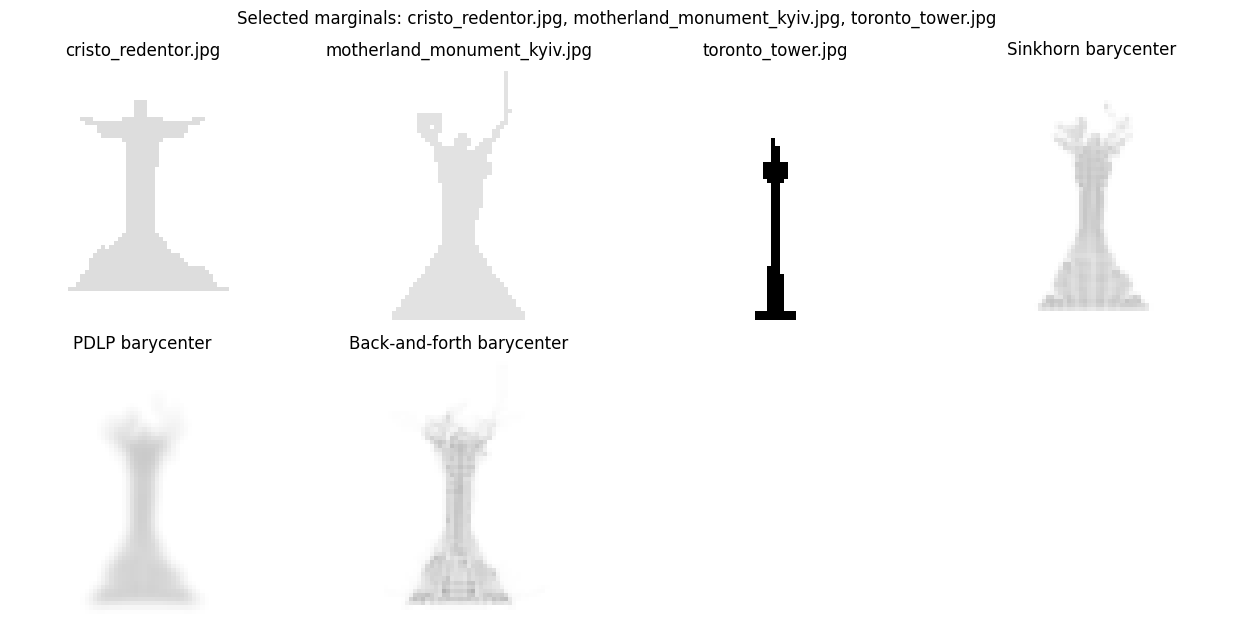

In [20]:
fields = measure_fields + [sinkhorn_field, bnf_field]
titles = selected_names + ['Sinkhorn barycenter', 'Back-and-forth barycenter']

fields = measure_fields + [sinkhorn_field, pdlp_field, bnf_field]
titles = selected_names + ['Sinkhorn barycenter', 'PDLP barycenter', 'Back-and-forth barycenter']

vmax = max(np.max(f) for f in fields)
cols = 4
rows = int(np.ceil(len(fields) / cols))
fig, axes_plot = plt.subplots(rows, cols, figsize=(3.2 * cols, 3.2 * rows))
axes_plot = np.asarray(axes_plot).reshape(-1)

for ax, title, field in zip(axes_plot, titles, fields):
    plot_field(ax, np.rot90(field, k=1), axes=axes, title=title, vmin=0.0, vmax=vmax)

for ax in axes_plot[len(fields):]:
    ax.axis('off')

fig.suptitle('Selected marginals: ' + ', '.join(selected_names), fontsize=12)
fig.tight_layout()
plt.show()
